<a href="https://colab.research.google.com/github/ziatdinovmax/CSSAS-DML/blob/master/4_cssas_predictions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Prediction and postprocessing

Notebook prepared by Maxim Ziatdinov (October 2019)


---
This notebook applies trained neural network to extract positions of particles from the entire movie and then applies unsupervised statistical learning to the output of a neural network to get information on different particles "domains" and their evolution in time.


---




In [0]:
#@title Import modules
# Data manipulation and plotting
import os
import math
import time
import numpy as np
from collections import OrderedDict
from sklearn.cluster import MeanShift, estimate_bandwidth, KMeans
from sklearn.preprocessing import StandardScaler
from scipy import ndimage, spatial
import cv2
import imageio
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
# Neural networks
import torch
import torch.nn as nn
import torch.nn.functional as F

In [0]:
#@title Load custom modules { form-width: "20%" }

def load_torchmodel(weights_path, model):
    '''Loads saved weights into a model'''
    if torch.cuda.device_count() > 0:
        checkpoint = torch.load(weights_path)
    else:
        checkpoint = torch.load(weights_path, map_location='cpu')
    model.load_state_dict(checkpoint)
    return model
    
class conv2dblock(nn.Module):
    '''
    Creates a block consisting of convolutional
    layer, leaky relu and (optionally) dropout and
    batch normalization
    '''
    def __init__(self, input_channels, output_channels,
                 kernel_size=3, stride=1, padding=1,
                 use_batchnorm=False, lrelu_a=0.01,
                 dropout_=0):
        '''
        Args:
            input_channels: number of channels in the previous/input layer
            output_channels: number of the output channels for the present layer
            kernel_size: size (in pixels) of convolutional filter
            stride: value of convolutional filter stride
            padding: value of padding at the edges
            use_batchnorm (boolean): usage of batch normalization
            lrelu_a: value of alpha parameter in leaky/paramteric ReLU activation
            dropout_: value of dropout
        '''
        super(conv2dblock, self).__init__()
        block = []
        block.append(nn.Conv2d(input_channels,
                               output_channels,
                               kernel_size=kernel_size,
                               stride=stride,
                               padding=padding))
        if dropout_ > 0:
            block.append(nn.Dropout(dropout_))
        block.append(nn.LeakyReLU(negative_slope=lrelu_a))
        if use_batchnorm:
            block.append(nn.BatchNorm2d(output_channels))
        self.block = nn.Sequential(*block)

    def forward(self, x):
        '''Forward path'''
        output = self.block(x)
        return output

class dilation_block(nn.Module):
    '''
    Creates a block with dilated convolutional
    layers (aka atrous convolutions)
    '''
    def __init__(self, input_channels, output_channels,
                 dilation_values, padding_values,
                 kernel_size=3, stride=1, lrelu_a=0.01,
                 use_batchnorm=False, dropout_=0):
        '''
        Args:
            input_channels: number of channels in the previous/input layer
            output_channels: number of the output channels for the present layer
            dilation_values: list of dilation rates for convolution operation
            kernel_size: size (in pixels) of convolutional filter
            stride: value of convolutional filter stride
            padding: value of padding at the edges
            use_batchnorm (boolean): usage of batch normalization
            lrelu_a: value of alpha parameter in leaky/paramteric ReLU activation
            dropout_: value of dropout
            '''
        super(dilation_block, self).__init__()
        atrous_module = []
        for idx, (dil, pad) in enumerate(zip(dilation_values, padding_values)):
            input_channels = output_channels if idx > 0 else input_channels
            atrous_module.append(nn.Conv2d(input_channels,
                                           output_channels,
                                           kernel_size=kernel_size,
                                           stride=stride,
                                           padding=pad,
                                           dilation=dil,
                                           bias=True))
            if dropout_ > 0:
                atrous_module.append(nn.Dropout(dropout_))
            atrous_module.append(nn.LeakyReLU(negative_slope=lrelu_a))
            if use_batchnorm:
                atrous_module.append(nn.BatchNorm2d(output_channels))
        self.atrous_module = nn.Sequential(*atrous_module)

    def forward(self, x):
        '''Forward path'''
        atrous_layers = []
        for conv_layer in self.atrous_module:
            x = conv_layer(x)
            atrous_layers.append(x.unsqueeze(-1))
        return torch.sum(torch.cat(atrous_layers, dim=-1), dim=-1)

class upsample_block(nn.Module):
    '''
    Defines upsampling block performed either with
    bilinear interpolation followed by 1-by-1
    convolution or with a transposed convolution
    '''
    def __init__(self, input_channels, output_channels,
                 mode='interpolate', kernel_size=1,
                 stride=1, padding=0):
        '''
        Args:
            input_channels: number of channels in the previous/input layer
            output_channels: number of the output channels for the present layer
            mode: upsampling mode (default: 'interpolate')
            kernel_size: size (in pixels) of convolutional filter
            stride: value of convolutional filter stride
            padding: value of padding at the edges
            '''
        super(upsample_block, self).__init__()
        self.mode = mode
        self.conv = nn.Conv2d(
            input_channels, output_channels,
            kernel_size = kernel_size,
            stride = stride, padding = padding)
        self.conv_t = nn.ConvTranspose2d(
            input_channels, output_channels,
            kernel_size=2, stride=2, padding = 0)

    def forward(self, x):
        '''Defines a forward path'''
        if self.mode == 'interpolate':
            x = F.interpolate(
                x, scale_factor=2,
                mode='bilinear', align_corners=False)
            return self.conv(x)
        return self.conv_t(x)



class atomsegnet(nn.Module):
    '''
    Builds  a fully convolutional neural network model
    '''
    def __init__(self, nb_classes=1, nb_filters=32):
        '''
        Args:
            nb_filters: number of filters in the first convolutional layer
        '''
        super(atomsegnet, self).__init__()
        self.pxac = 'sigmoid' if nb_classes < 2 else 'softmax'
        self.c1 = conv2dblock(1, nb_filters)
        
        self.c2 = nn.Sequential(conv2dblock(nb_filters,
                                            nb_filters*2),
                                conv2dblock(nb_filters*2,
                                            nb_filters*2))
        
        self.c3 = nn.Sequential(conv2dblock(nb_filters*2,
                                            nb_filters*4,
                                            dropout_=0.3),
                                conv2dblock(nb_filters*4,
                                            nb_filters*4,
                                            dropout_=0.3))
        
        self.bn = dilation_block(nb_filters*4,
                                 nb_filters*8,
                                 dilation_values=[2, 4, 6],
                                 padding_values=[2, 4, 6],
                                 dropout_=0.5)
        
        self.upsample_block1 = upsample_block(nb_filters*8,
                                              nb_filters*4)
        
        self.c4 = nn.Sequential(conv2dblock(nb_filters*8,
                                            nb_filters*4,
                                            dropout_=0.3),
                                conv2dblock(nb_filters*4,
                                            nb_filters*4,
                                            dropout_=0.3))
        
        self.upsample_block2 = upsample_block(nb_filters*4,
                                              nb_filters*2)
        
        self.c5 = nn.Sequential(conv2dblock(nb_filters*4,
                                            nb_filters*2),
                                conv2dblock(nb_filters*2,
                                            nb_filters*2))
        
        self.upsample_block3 = upsample_block(nb_filters*2,
                                              nb_filters)
        
        self.c6 = conv2dblock(nb_filters*2,
                              nb_filters)
        
        self.px = nn.Conv2d(nb_filters,
                            nb_classes,
                            kernel_size=1,
                            stride=1,
                            padding=0)
               
    def forward(self, x):
        '''Defines a forward path'''
        # Contracting path
        c1 = self.c1(x)
        d1 = F.max_pool2d(c1, kernel_size=2, stride=2)
        c2 = self.c2(d1)
        d2 = F.max_pool2d(c2, kernel_size=2, stride=2)
        c3 = self.c3(d2)
        d3 = F.max_pool2d(c3, kernel_size=2, stride=2)
        # Atrous convolutions
        bn = self.bn(d3)
        # Expanding path
        u3 = self.upsample_block1(bn)
        u3 = torch.cat([c3, u3], dim=1)
        u3 = self.c4(u3)
        u2 = self.upsample_block2(u3)
        u2 = torch.cat([c2, u2], dim=1)
        u2 = self.c5(u2)
        u1 = self.upsample_block3(u2)
        u1 = torch.cat([c1, u1], dim=1)
        u1 = self.c6(u1)
        # pixel-wise classification
        px = self.px(u1)
        if self.pxac == 'sigmoid':
            output = torch.sigmoid(px)
        elif self.pxac == 'softmax':
            output = F.log_softmax(px, dim=1)
        return output


def torch_format(images, norm=1):
    '''Reshapes dimensions, normalizes (optionally)
       and converts image data to a pytorch float tensor.
       (assumes mage data is stored as numpy array)'''
    if images.ndim == 2:
        images = np.expand_dims(images, axis=0)
    images = np.expand_dims(images, axis=1)
    if norm != 0:
        images = (images-np.amin(images))/np.ptp(images)
    images = torch.from_numpy(images).float()
    return images


def predict(images, model, use_gpu=False):
    '''Returns probability (as seen by neural network)
    of each pixel in image belonging to a defect'''
    if use_gpu:
        model.cuda()
        images = images.cuda()
    model.eval()
    with torch.no_grad():
        prob = model.forward(images)
    if use_gpu:
        model.cpu()
        images = images.cpu()
        prob = prob.cpu()
    prob = prob.permute(0, 2, 3, 1)
    return prob


def threshold_output(imgdata, t=0.5):
    '''Binary threshold of an output of a neural network'''
    imgdata_ = cv2.threshold(imgdata, t, 1, cv2.THRESH_BINARY)[1]
    return imgdata_

def filter_single_frame(imgdata, output_thresh, size_thresh):
    '''Filters out blobs above cetrain size
    in the thresholded neural network output'''
    imgdata = threshold_output(imgdata, output_thresh)
    label_img, cc_num = ndimage.label(imgdata)
    cc_areas = ndimage.sum(imgdata, label_img, range(cc_num + 1))
    area_mask = (cc_areas < size_thresh)
    label_img[area_mask[label_img]] = 0
    label_img[label_img > 0] = 1
    return label_img

def filter_cells(imgdata, output_thresh=0.5, size_thresh=20):
    '''Filters blobs for each image in the stack'''
    filtered_stack = np.zeros_like(imgdata)
    for i, img in enumerate(imgdata):
        filtered_stack[i] = filter_single_frame(img, output_thresh, size_thresh)
    return filtered_stack

def find_blobs(imgdata):
    '''Finds position of defects in the processed output
       of a neural network via center of mass method'''
    labels, nlabels = ndimage.label(imgdata)
    coordinates = ndimage.center_of_mass(
        imgdata, labels, np.arange(nlabels)+1)
    coordinates = np.array(coordinates, dtype=np.float)
    coordinates = coordinates.reshape(coordinates.shape[0], 2)
    return coordinates


def remove_edge_coord(imgdata, coordinates, dist_edge=20):
    '''Removes coordinates too close to image edges'''
    def coord_edges(coordinates, w, h, dist_edge):
        return [coordinates[0] > w - dist_edge,
                coordinates[0] < dist_edge,
                coordinates[1] > h - dist_edge,
                coordinates[1] < dist_edge]
    w, h = imgdata.shape[0:2]
    coord_to_rem = [idx for idx, c in enumerate(coordinates) if
                    any(coord_edges(c, w, h, dist_edge))]
    coord_to_rem = np.array(coord_to_rem, dtype=int)
    coordinates = np.delete(coordinates, coord_to_rem, axis=0)
    return coordinates

def get_contours(imgdata):
    """Extracts contours from image data (image data must be binary thresholded)"""
    imgdata_ = cv2.convertScaleAbs(imgdata)
    contours = cv2.findContours(
        imgdata_.copy(), cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)[1]
    return contours

def get_trajectories(exp_images, network_output):
    """Extracts position and angle for each particle for each movie frame"""
    trajectories = {}
    for i, frame in enumerate(network_output):
        contours = get_contours(frame)
        dictionary = OrderedDict()
        com_arr = np.empty((0, 2))
        angles = []
        for cnt in contours:
            try:
                (com), _, angle = cv2.fitEllipse(cnt)
            except:
                continue
            com = np.array(com)
            com_arr = np.append(com_arr, [com], axis=0)
            angles.append(angle)
        dictionary['experimental'] = exp_images[i, 0, :, :]
        dictionary['decoded'] = frame
        dictionary['coordinates'] = com_arr
        dictionary['angles'] = np.array(angles)
        trajectories[i] = dictionary
    return trajectories


class dl_image:
    '''
    Image decoder with a trained neural network
    '''
    def __init__(self, image_data, model, *args, nb_classes=1,
                 max_pool_n=3, norm=1, use_gpu=False,
                 histogram_equalization=False):
        '''
        Args:
            image_data (ndarray): image stack or a single image (all greyscale)
            model: trained pytorch model
            nb_classes: number of classes in the model
            max_pool_n: number of max-pooling layers in the model
            norm: image normalization to 1
            use_gpu: optional use of gpu device for inference
            histogram_equalization: Equilazes image histogram
            args: tuple with image width and heigh for resizing operation
        '''
        if image_data.ndim == 2:
            image_data = np.expand_dims(image_data, axis=0)
        self.image_data = image_data
        try:
            self.rs = args[0]
        except IndexError:
            self.rs = image_data.shape[1:3]
        self.model = model
        self.nb_classes = nb_classes
        self.max_pool_n = max_pool_n
        self.norm = norm
        self.use_gpu = use_gpu
        self.hist_equ = histogram_equalization
    
    def img_resize(self):
        '''Image resizing (optional)'''
        if self.image_data.shape[1:3] == self.rs:
            return self.image_data.copy()
        image_data_r = np.zeros((self.image_data.shape[0],
                                 self.rs[0], self.rs[1]))
        for i, img in enumerate(self.image_data):
            img = cv2.resize(img, (self.rs[0], self.rs[1]))
            image_data_r[i, :, :] = img
        return image_data_r
        
    def img_pad(self, *args):
        '''Pads the image if its size (w, h)
        is not divisible by 2**n, where n is a number
        of max-pooling layers in a network'''
        try:
            image_data_p = args[0]
        except IndexError:
            image_data_p = self.image_data
        # Pad image rows (height)
        while image_data_p.shape[1] % 2**self.max_pool_n != 0:
            d0, _, d2 = image_data_p.shape
            image_data_p = np.concatenate(
                (image_data_p, np.zeros((d0, 1, d2))), axis=1)
        # Pad image columns (width)
        while image_data_p.shape[2] % 2**self.max_pool_n != 0:
            d0, d1, _ = image_data_p.shape
            image_data_p = np.concatenate(
                (image_data_p, np.zeros((d0, d1, 1))), axis=2)

        return image_data_p

    def hist_equalize(self, *args, number_bins=5):
        '''Histogram equalization (optional)'''
        try:
            image_data_ = args[0]
        except IndexError:
            image_data_ = self.image_data
     
        def equalize(image):
            image_hist, bins = np.histogram(image.flatten(), number_bins)
            cdf = image_hist.cumsum()
            #cdf_normalized = cdf * image_hist.max()/ cdf.max()
            image_equalized = np.interp(image.flatten(), bins[:-1], cdf)
            return image_equalized.reshape(image.shape)

        image_data_h = np.zeros(shape=image_data_.shape)
        for i, img in enumerate(image_data_):
            img = equalize(img)
            image_data_h[i, :, :] = img

        return image_data_h


    def torch_format(self, image_data_):
        '''Reshapes and normalizes (optionally) image data
        to make it compatible with pytorch format'''
        image_data_ = np.expand_dims(image_data_, axis=1)
        if self.norm != 0:
            image_data_ = (image_data_ - np.amin(image_data_))/np.ptp(image_data_)
        image_data_ = torch.from_numpy(image_data_).float()
        return image_data_
    
    def predict(self, images):
        '''Returns probability of each pixel
           in image belonging to an atom'''
        if self.use_gpu:
            self.model.cuda()
            images = images.cuda()
        self.model.eval()
        with torch.no_grad():
            prob = self.model.forward(images)
            if self.nb_classes > 1:
                prob = torch.exp(prob)
        if self.use_gpu:
            self.model.cpu()
            images = images.cpu()
            prob = prob.cpu()
        prob = prob.permute(0, 2, 3, 1) # reshape with channel=last as in tf/keras
        prob = prob.numpy()

        return prob
    
    def decode(self):
        '''Make prediction'''
        image_data_ = self.img_resize()
        if self.hist_equ:
            image_data_ = self.hist_equalize(image_data_)
        image_data_ = self.img_pad(image_data_)
        image_data_torch = self.torch_format(image_data_)
        start_time = time.time()
        if image_data_torch.shape[0] < 20 and min(image_data_torch.shape[2:4]) < 512:
            decoded_imgs = self.predict(image_data_torch)
        else:
            n, _, w, h = image_data_torch.shape
            decoded_imgs = np.zeros((n, w, h, self.nb_classes))
            for i in range(n):
                decoded_imgs[i, :, :, :] = self.predict(image_data_torch[i:i+1])
        n_images_str = " image was " if decoded_imgs.shape[0] == 1 else " images were "
        print(str(decoded_imgs.shape[0]) + n_images_str + "decoded in approximately "
              + str(np.around(time.time() - start_time, decimals=2)) + ' seconds')
        image_data_torch = image_data_torch.permute(0, 2, 3, 1)
        images_numpy = image_data_torch.numpy()
        return images_numpy, decoded_imgs

def make_animation(trajectories, figdir, moviename):
    '''
    Creates and saves a gif animation from decoded "movie" data
    
    Args:
        img: 3D numpy array
            Experimental data
        dec: 3D numpy array
            Neural network output
        coord: dict
            Coordinates of atoms in each frame (key: frame number)
        figdir: string
            Directory for saving individual frames and gif animation
        moviename: string
            Name of animation file
    '''
    # Create new directory
    if not os.path.exists(figdir):
        os.makedirs(figdir)  
    # Store movie frames as .png files in the new directory
    fig = plt.figure(figsize = (12, 12), dpi = 100)
    ax1 = fig.add_subplot(331)
    ax2 = fig.add_subplot(332)
    ax3 = fig.add_subplot(333)
    for k in range(len(trajectories)):
        #for _ax in fig.axes:
        #    _ax.cla()
        experimental, decoded, coordinates, angles = trajectories[k].values()
        angles = np.array([math.radians(i) for i in angles])
        angles = angles%math.pi
        x, y = coordinates.T
        ax1.imshow(experimental , cmap = 'gray')
        ax1.set_title('Experimental image')
        ax2.imshow(experimental, cmap = 'gray')
        ax2.imshow(decoded, cmap = 'jet', Interpolation = 'Gaussian', alpha=1.)
        ax2.set_title('Model prediction')
        ax3.quiver(x, y, np.sin(angles), np.cos(angles), color='black')
        ax3.set_xlim(0, 512)
        ax3.set_ylim(512, 0)
        ax3.set_title('Proteins position and orientation')
        for _ax in fig.axes:
            _ax.axis('off')
        fig.savefig(os.path.join(figdir, 'frame-{}.png'.format(k)))
        for _ax in fig.axes:
            _ax.cla()
        plt.close(fig)
    # Read saved movie frames and save them as .gif animation
    images = []
    for file_name in os.listdir(figdir):
        if file_name.endswith('.png'):
            images.append(imageio.imread(os.path.join(figdir, file_name)))
    imageio.mimsave(os.path.join(figdir, moviename + '.gif'), images)
    return

Mount google drive:

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


Set a working directory (a folder with all the files relevant to this analysis):

In [0]:
workdir = '/content/drive/Shared drives/CSSAS-ML'

%cd $workdir

/content/drive/Shared drives/CSSAS-ML


##Inference on Experimental Data

We load best/final weights of our trained model:

In [0]:
#weights_path = 'saved_models/pnnl-100mL-part2-8.pt'
weights_path = 'saved_models/pnnl-model-1.pt'
model = atomsegnet()
model = load_torchmodel(weights_path, model)

Load experimental data:

In [0]:
expdata = np.load('exp_data/KCl 100mM-full.npy')

Apply trained model to the experimental data:

In [0]:
expdata_, X_prob = dl_image(expdata, model, use_gpu=True).decode()
X_prob = filter_cells(X_prob[:, :, :, 0], 0.5, 50)
trajectories = get_trajectories(np.transpose(expdata_, (0, -1, 1, 2)), X_prob)

603 images were decoded in approximately 53.33 seconds


Plot results (for a selected frame):

Text(0.5, 1.0, 'Proteins position and orientation')

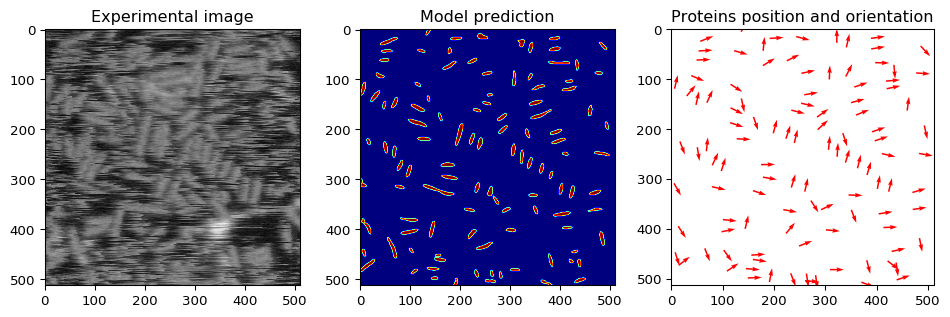

In [0]:
k = 50 # selected frame

# get data for the selected frame
experimental, decoded, coordinates, angles = trajectories[k].values()
angles = np.array([math.radians(i) for i in angles])
angles = angles%math.pi
x, y = coordinates.T

# Plotting
fig = plt.figure(figsize = (12, 12), dpi = 96)
ax1 = fig.add_subplot(331)
ax2 = fig.add_subplot(332)
ax3 = fig.add_subplot(333)
ax1.imshow(experimental , cmap = 'gray')
ax1.set_title('Experimental image')
ax2.imshow(experimental, cmap = 'gray')
decoded_ = np.copy(decoded)
#decoded_[130:250, 350:450] = 0
ax2.imshow(decoded_, cmap = 'jet', Interpolation = 'Gaussian', alpha=1.)
ax2.set_title('Model prediction')
ax3.quiver(x, y, np.sin(angles), np.cos(angles), color='red')
ax3.set_xlim(0, 512)
ax3.set_ylim(512, 0)
ax3.set_title('Proteins position and orientation')

Save the decoded results as animation:

In [0]:
#make_animation(trajectories, 'mica-100mM-png', 'mica-100mM-animation')

Plot all the coordinates for every frame  as a 3D plot:

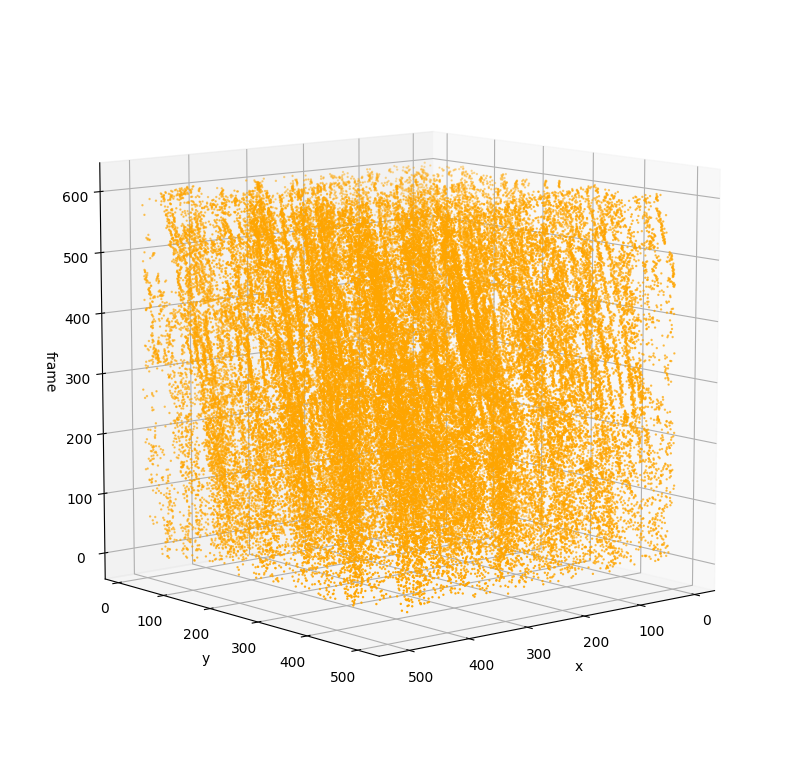

In [0]:
fig = plt.figure(figsize=(10, 10), dpi = 100)
ax = fig.add_subplot(111, projection='3d')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('frame')

for k, v in trajectories.items():
    coordinates = v['coordinates']
    ax.scatter(coordinates[:, 0], coordinates[:, 1], k, s=0.5, c='orange')

ax.view_init(10, 50)
ax.axis('equal')
ax.auto_scale_xyz([0, 512], [0, 512], [0, len(trajectories)])

## Statistical analysis

Get particle angles distribution:

In [0]:
angles_all = np.empty((0))
coord_all = np.empty((0, 2))
frames_all = []
for k, v in trajectories.items():
    angles = v['angles']
    coord = v['coordinates']
    angles_all = np.append(angles_all, angles)
    coord_all = np.append(coord_all, coord, axis=0)
    frames_all.extend([k]*len(angles))

(array([    0.,  2000.,  4000.,  6000.,  8000., 10000., 12000., 14000.]),
 <a list of 8 Text yticklabel objects>)

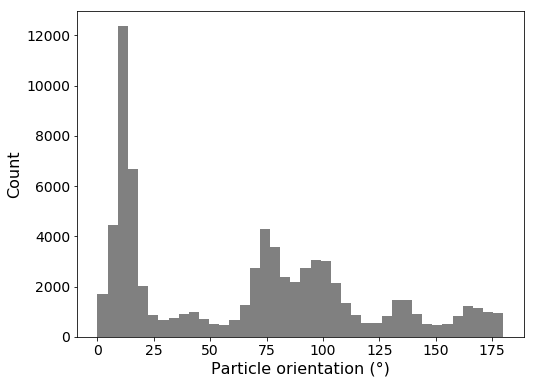

In [0]:
plt.figure(figsize=(8, 6))
_ = plt.hist(angles_all, bins=40, color='gray')
plt.xlabel('Particle orientation (°)', fontsize=16)
plt.ylabel('Count', fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

Cluster particles based on angles:

In [0]:
def meanshift_clustering(X, q=0.1, with_mean=False, with_std=False):
    """
    Performs mean-shift clustering
    Returns 1d vector with labels
    and cluster centers
    """
    X = StandardScaler(with_mean=with_mean, with_std=with_std).fit_transform(X)
    bandwidth = estimate_bandwidth(X, quantile=q)
    ms = MeanShift(bandwidth=bandwidth, bin_seeding=True)
    ms.fit(X)
    return ms.predict(X), ms.cluster_centers_

# Run mean-shift clustering
labels, cluster_centers = meanshift_clustering(angles_all.reshape(-1, 1))
print("Cluster centers (deg):\n", cluster_centers)

Cluster centers (deg):
 [[ 11.91924982]
 [ 75.74951215]
 [ 97.45906696]
 [135.09414377]
 [167.36177527]
 [ 40.30355911]]


Plot clustering results for a selected frame:

(0.0, 512.0, 512.0, 0.0)

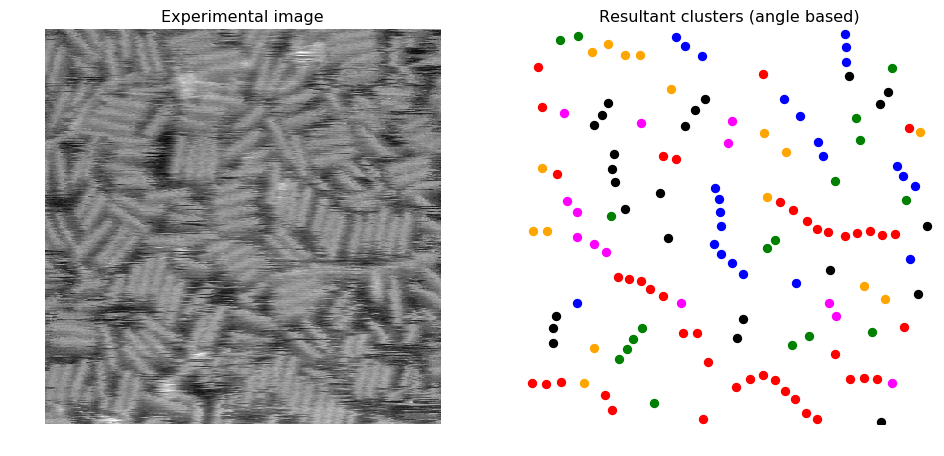

In [0]:
my_colors = ['red', 'blue', 'black', 'green', 'orange', 
             'magenta', 'yellow', 'navy', 'maroon', 'sandybrown']

k = 200
clusters_to_plot = [0, 1, 2, 3, 4, 5]

experimental = trajectories[k]['experimental']
idx_filtered = np.where(np.array(frames_all)==k)
labels_filtered = labels[idx_filtered]
coord_filtered = coord_all[idx_filtered]

fig = plt.figure(figsize = (12, 12), dpi = 96)
ax1 = fig.add_subplot(221)
ax2 = fig.add_subplot(222)
ax1.imshow(experimental, cmap = 'gray')
ax1.set_title('Experimental image')
for (x_i, y_i), l in zip(coord_filtered, labels_filtered):
    if l in clusters_to_plot:
        ax2.scatter(x_i, y_i, c = my_colors[l])
ax2.set_xlim(0, 512)
ax2.set_ylim(512, 0)
ax2.set_title('Resultant clusters (angle based)')
ax1.axis('off')
ax2.axis('off')

Now plot spatio-temporal trajectories of all the clusters:

(the plotting itself may take some time - up to 10 minutes; this needs to be optimized in the future)

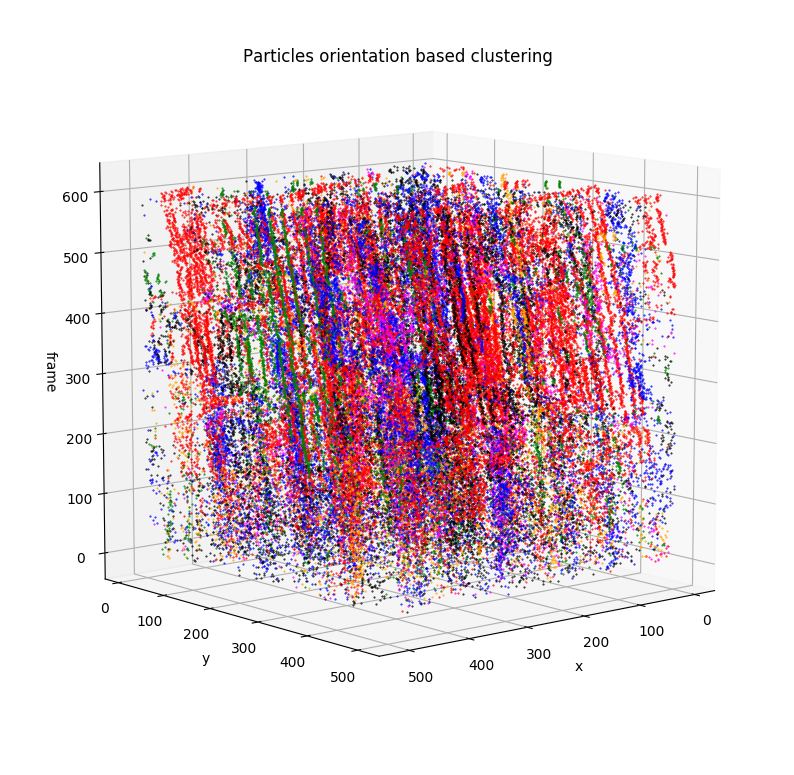

In [0]:
clusters_to_plot = [0, 1, 2, 3, 4, 5]
fig = plt.figure(figsize=(10, 10), dpi = 100)
ax = fig.add_subplot(111, projection='3d')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('frame')

for c, l, k in zip(coord_all, labels, frames_all):
    if l in clusters_to_plot:
        ax.scatter(c[0], c[1], k, c = my_colors[l], s = 0.2)

ax.set_title('Particles orientation based clustering')
ax.view_init(10, 50)
ax.axis('equal')
ax.auto_scale_xyz([0, 512], [0, 512], [0, len(trajectories)])

Plot evolution in size of different clusters:

Plotting size evolution of selected clusters....


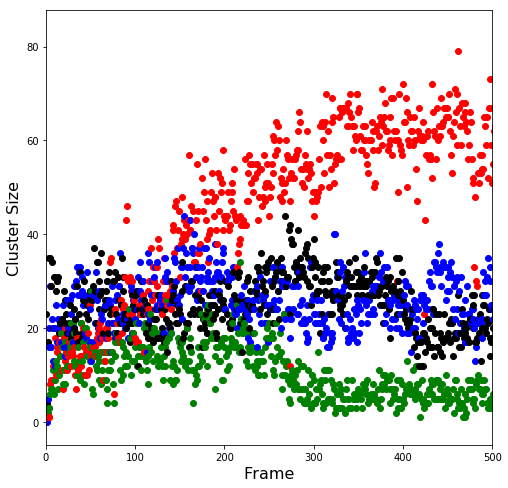

cluster center: 11.919249817000287  -  label: red
cluster center: 75.74951215247792  -  label: blue
cluster center: 97.45906696302066  -  label: black
cluster center: 167.36177527195204  -  label: green


In [0]:
clusters_to_count = [0, 1, 2, 4]
print("Plotting size evolution of selected clusters....")
plt.figure(figsize=(8, 8))
for k in trajectories.keys():
    idx_filtered = np.where(np.array(frames_all)==k)
    labels_filtered = labels[idx_filtered]
    for cluster_idx, color in zip(clusters_to_count, my_colors):
        cluster_len = len(np.where(labels_filtered==cluster_idx)[0])
        plt.scatter(k, cluster_len, c=color)
plt.xlim(0, 500)
plt.xlabel('Frame', fontsize=16)
plt.ylabel('Cluster Size', fontsize=16)
plt.show()
i = 0
for j, clc in enumerate(cluster_centers):
    if j in clusters_to_count:
        print('cluster center: {}  -  label: {}'.format(clc[0], my_colors[i]))
        i += 1